# Step by step code for  abide_motion_wrapper.py 

In [89]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import ticker
from glob import glob
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress, pearsonr, spearmanr
import nibabel as nib
import urllib
import seaborn as sns
sns.set_context('notebook', font_scale=2)
sns.set_style('white')


### Read in the phenotypic behavioural data

This is the **Phenotypic_V1_0b_preprocessed1.csv** file. It's saved in the **DATA** folder.

You can find the explanations of all the columns in the **ABIDE_LEGEND_V1.02.pdf** file.

We're going to load the data into a pandas data frame.

In [65]:
behav_data_f = 'DATA/Phenotypic_V1_0b_preprocessed.csv'
df = pd.read_csv(behav_data_f)

Our measure of interest is **func_perc_fd** so lets get rid of all participants who don't have a value!

We also want to make sure our data **has the data** so lets get rid of all participants who's file ID is "no_filename".

We also want to know the **age in years** for each participant.

In [66]:
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])

### Create a stratified sample

We want to see how similar the average connectivity values are ***when there are no differences between the groups***.

Therefore we need to split participants into ***matched*** samples.

What do they need to be matched on?!

* DSM_IV_TR -- their diagnosis according to the DSM IV (0: control, 1: ASD, 2: Asp, 3: PDD)
* SITE_ID -- the scanning site
* AGE_YRS -- age in years
* SEX -- sex (1: male, 2: female)

We also want to make sure that we sample evenly from the distribution of motion. This will prevent us from over sampling the low motion people, for which we have more data on.

### Threshold your sample according to the motion/age cut offs

We're going to systematically change the upper threshold of the percent of volumes that exceed 0.2mm frame to frame dispacement.

And we're also going to select our lower and upper age limits. NOTE that these are inclusive boundaries. So for example a lower limit of 6 and an upper limit of 10 will include participants who are 6, 7, 8, 9 and 10 years old.

* func_perc_fd
* AGE_YRS

In [24]:
motion_thresh = 80
df_samp_motion = df.loc[df['func_perc_fd']<motion_thresh, :]

In [25]:
age_l, age_u = 6, 18
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l) & (df_samp_motion['AGE_YRS']<=age_u), :]

### Look at distribution of motion in sample

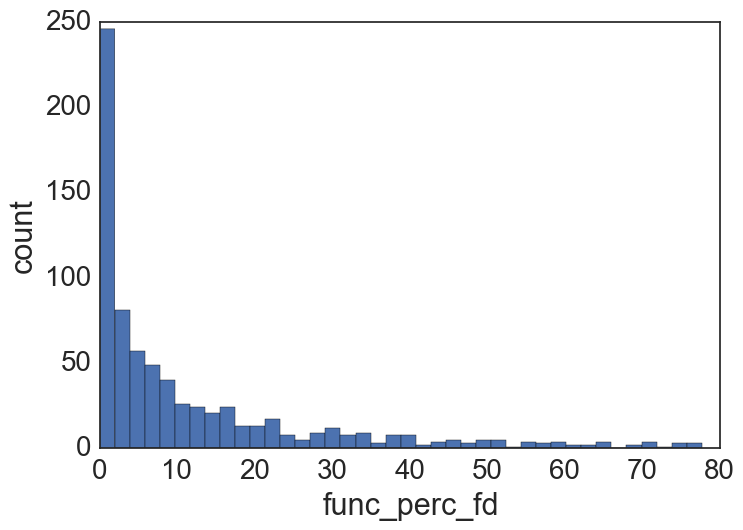

In [26]:
plt.hist(np.array(df_samp ["func_perc_fd"]),bins=40)
plt.xlabel('func_perc_fd')
plt.ylabel('count')

### To avoid oversampling the many low movers, we are going to split up our data into 4 motion quartiles and evenly sample from them 

To do this we are going to:
* sort our sample based on motion and then add a column of their ranking
* based on our sample of motion, create motion quartile cutoffs
* create bins of subjects by motion quartile cutoffs


**First we will sort our sample based on motion ('Func_perc_fd')**

In [7]:
##sort subjects based on motion
sort_column_list = ['func_perc_fd']
df_motion_sorted = df_samp.sort_values(by=sort_column_list)
#check that sorted worked!
df = df_motion_sorted[['func_perc_fd', "SUB_ID"]]
df.head(10)
#df.tail(10)

,func_perc_fd,SUB_ID
93,0,50142
190,0,50267
809,0,51126
259,0,50336
116,0,50167
115,0,50166
811,0,51128
635,0,50819
733,0,51049
818,0,51135


In [8]:
 ##rank subjects by motion
r=range(len(df_motion_sorted))
r_df=pd.DataFrame(r)
r_df.columns = ['rank']
r_df['newcol'] = df_motion_sorted.index
r_df.set_index('newcol', inplace=True)
r_df.index.names = [None]
df_motion_sorted_rank=pd.concat ([r_df,df_motion_sorted], axis=1)

Let's check to make sure we correctly sorted our subjects by motion

/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


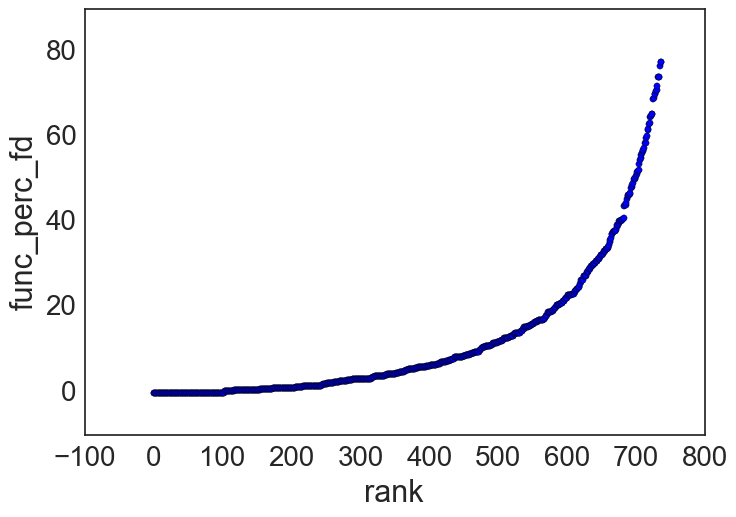

In [9]:
plt.scatter(np.array(df_motion_sorted_rank["rank"]), np.array(df_motion_sorted_rank['func_perc_fd']))
plt.xlabel('rank')
plt.ylabel('func_perc_fd')

**Now, based on our sample of motion, create motion quartile cutoffs **

In [27]:
 ##create bins of subjects in quartiles
l=len(df_motion_sorted_rank)
chunk=l/4
chunk1=chunk
chunk2=2*chunk
chunk3=3*chunk
chunk4=l
    

** Then create bins of subjects by motion quartile cutoffs **

In [11]:
first=df_motion_sorted_rank[df_motion_sorted_rank['rank']<=chunk1]
second=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk1) & (df_motion_sorted_rank['rank']<=chunk2)]
third=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk2) & (df_motion_sorted_rank['rank']<=chunk3)]
fourth=df_motion_sorted_rank[df_motion_sorted_rank['rank']>=chunk3]
    

** Look at what our sampling look like **

In [12]:
motion_boundaries = (first.func_perc_fd.max(), second.func_perc_fd.max(), third.func_perc_fd.max())
for boundary in motion_boundaries:
    print boundary

0.996677741
5.315614618
16.27906977


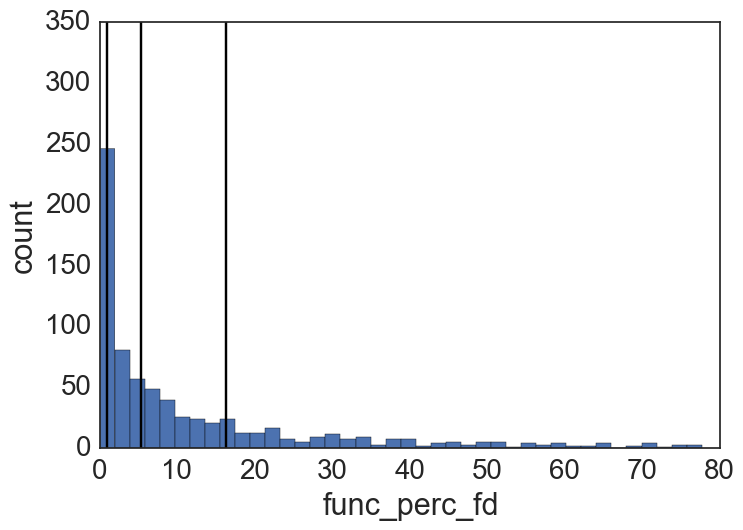

In [13]:
plt.hist(np.array(df["func_perc_fd"]),bins=40)
plt.xlabel('func_perc_fd')
plt.ylabel('count')
for boundary in motion_boundaries:
    plt.plot((boundary, boundary), (0,350), 'k-')

Looks good! We are evently sampling from all motion bins

### Only keep 2n/4 participants from each bin

Remember to shuffle these remaining participants to ensure you get different sub samples each time you run the code.

In [28]:
##shuffle
first_rand = first.reindex(np.random.permutation(first.index))
second_rand = second.reindex(np.random.permutation(second.index))
third_rand = third.reindex(np.random.permutation(third.index))
fourth_rand = fourth.reindex(np.random.permutation(fourth.index))

In [29]:
#Only keep the top 2*n/4 participants.
n=50
n_samp=(n*2)/4
n_samp

first_samp_2n = first_rand.iloc[:n_samp, :]
second_samp_2n = second_rand.iloc[:n_samp, :]
third_samp_2n = third_rand.iloc[:n_samp, :]
fourth_samp_2n = fourth_rand.iloc[:n_samp, :]

### Append all the samples together into one big dataframe and then sort according to matching measures

In [30]:
#append these together
frames = [first_samp_2n, second_samp_2n, third_samp_2n,fourth_samp_2n]
final_df = pd.concat(frames)

In [31]:
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_AT_SCAN']
df_samp_2n_sorted = final_df.sort_values(by=sort_column_list)

### Split this data frame into two and VOILA

In [32]:
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

### Actually this can be implemented as a function

The inputs to `split_two_matched_samples` are the master data frame (`df`), the motion threshold (`motion_thresh`), lower age limit (`age_l`), upper age limit (`age_u`) and the number of participants (`n`) in each group.

In [90]:
from abide_motion_wrapper import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 80, 6, 18, 200)

print df_A[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()
print df_B[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()


       AGE_AT_SCAN    DX_GROUP         SEX
count   200.000000  200.000000  200.000000
mean     12.735278    1.550000    1.165000
std       2.921744    0.498742    0.372112
min       7.000000    1.000000    1.000000
25%      10.612500    1.000000    1.000000
50%      12.655000    2.000000    1.000000
75%      14.938825    2.000000    1.000000
max      18.590000    2.000000    2.000000
       AGE_AT_SCAN    DX_GROUP         SEX
count   200.000000  200.000000  200.000000
mean     12.879452    1.540000    1.150000
std       2.929855    0.499648    0.357967
min       6.470000    1.000000    1.000000
25%      10.705000    1.000000    1.000000
50%      12.790000    2.000000    1.000000
75%      14.715000    2.000000    1.000000
max      18.900000    2.000000    2.000000


## Now that we have our groups, we are going to want to load in the actual AAL ROI times series files and make individual and group correlation matrices



We already have the aal time series files downloaded in the `DATA` folder, but if you wanted to download them yourselves, you can use the code below

In [42]:
## to grab data 

for f_id in df.loc[:, 'FILE_ID']:
    
    if not (f_id == "no_filename") and not os.path.isfile("../DATA/{}_rois_aal.1D".format(f_id)):
        print f_id
        testfile = urllib.URLopener()
    
        testfile.retrieve(("https://s3.amazonaws.com/fcp-indi/data/Projects"
                           "/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_aal"
                           "/{}_rois_aal.1D".format(f_id)), 
                              "DATA/{}_rois_aal.1D".format(f_id))


### The function below (make_group_corr_mat) creates individual and group roi-roi correlation matrices by:
* Reading in each subjects AAL roi time series file (in `DATA` folder).  Each column is a AAL ROI and the rows below correspond to its average time series. 
* Create roi-roi correlation matrices for each subject
* Fischer Z transforming the correlation matrices
* Concatonating all subjects roi-roi matrices and creating a mean and variance roi-roi correlation matrix

In [68]:
## looking at an example aal time series file for one subject 
test = 'DATA/NYU_0051076_rois_aal.1D'
tt = pd.read_csv(test, sep='\t')
tt.head()

,#2001,#2002,#2101,#2102,#2111,#2112,#2201,#2202,#2211,#2212,...,#9081,#9082,#9100,#9110,#9120,#9130,#9140,#9150,#9160,#9170
0,-2.946018,-1.941137,5.392750,6.295335,5.187988,-2.902794,-0.684843,-1.645337,-1.051671,1.213482,...,3.607126,-10.493627,-37.271429,-17.832887,25.373078,2.817335,0.109425,8.604893,-22.066793,-4.102947
1,-2.026330,-3.210238,0.271845,-1.307281,4.873410,-6.341721,-4.807414,-12.619873,-6.033208,-9.221462,...,5.959049,-7.829721,-23.175646,-1.290443,37.657219,-1.461262,6.400433,13.848265,-18.222066,24.534787
2,-3.925096,-4.471406,-7.105514,-9.349305,-1.855909,-5.780155,-10.120288,-19.592072,-17.626062,-19.280951,...,6.422434,9.333579,6.962992,16.628420,16.478461,-5.586753,16.567155,13.026882,6.453235,44.573676
3,-7.749468,-2.947181,-8.817094,-7.038360,-10.518508,-1.984887,-12.257562,-16.084317,-30.834229,-20.907734,...,2.857940,20.377554,17.348361,11.110790,-29.966750,-4.038938,16.416830,5.618465,31.157536,33.534571
4,-9.375709,2.289316,-2.810755,5.581215,-14.871998,0.091656,-8.730465,-6.197355,-36.107290,-12.902872,...,-4.624507,7.328061,-2.084836,-20.083847,-69.615823,2.266175,-0.693772,-4.859262,32.589354,-5.118252


In [69]:
def make_group_corr_mat(df):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        # read each subjects aal roi time series files
        ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

        # create a correlation matrix from the roi all time series files
        corr_mat_r = ts_df.corr()
        
        # the correlations need to be transformed to Fisher z, which is
        # equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        # for the first subject, create a correlation matrix of zeros
        # that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])

        # now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        all_corr_mat[:, :, i] = corr_mat_z
            
    # create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    # create the group covariance matrix (ignore nas - sometime there are some...)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat

Make the group correlation matrices for the two different groups.

In [70]:
M_grA, M_grA_av, M_grA_var = make_group_corr_mat(df_A)
M_grB, M_grB_av, M_grB_var = make_group_corr_mat(df_B)

### Check out the distributions of the r and z values in one of the correlation matrices

Just to see what happens to the data when you apply the `arctanh` transform.

(The answer is: not too much!)

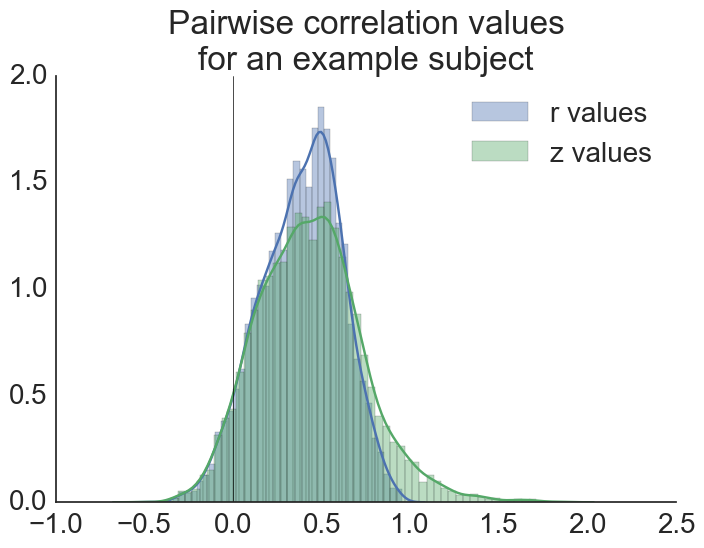

In [72]:
sub, f_id = df[['SUB_ID', 'FILE_ID']].values[0]

ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))
corr_mat_r = ts_df.corr()
corr_mat_z = np.arctanh(corr_mat_r)

r_array = np.triu(corr_mat_r, k=1).reshape(-1)
z_array = np.triu(corr_mat_z, k=1).reshape(-1)
sns.distplot(r_array[r_array<>0.0], label='r values')
sns.distplot(z_array[z_array<>0.0], label='z values')

plt.axvline(c='k', linewidth=0.5)

plt.legend()

plt.title('Pairwise correlation values\nfor an example subject')
sns.despine()

### Visually check the average correlation matrices for the two groups


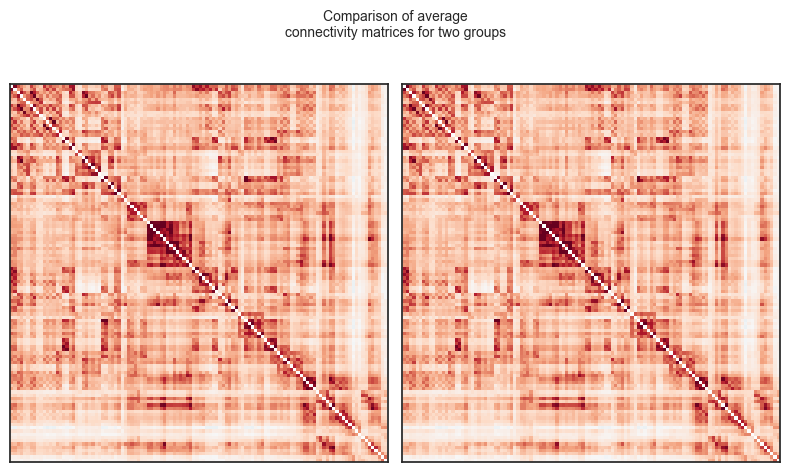

In [73]:
fig, ax_list = plt.subplots(1,2)

ax_list[0].imshow(M_grA_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)
ax_list[1].imshow(M_grB_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)

for ax in ax_list:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.suptitle('Comparison of average\nconnectivity matrices for two groups')

plt.tight_layout()

### Scatter plot of the two connectivity matrices 


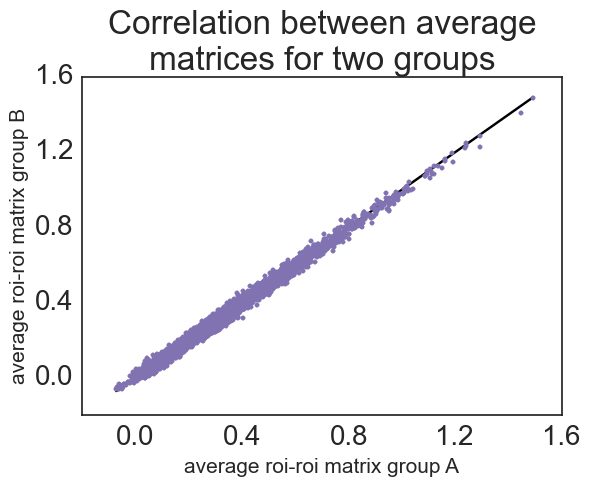

In [79]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = M_grA_av[indices]
grB_values = M_grB_av[indices]

min_val = np.min([np.min(grA_values), np.min(grB_values)])
max_val = np.max([np.max(grA_values), np.max(grB_values)])

fig, ax = plt.subplots(figsize=(6,5))
ax.plot([np.min(grA_values), np.max(grA_values)], [np.min(grA_values), np.max(grA_values)], c='k', zorder=-1)
ax.scatter(grA_values, grB_values, color=sns.color_palette()[3], s=10, edgecolor='face')

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

plt.xlabel('average roi-roi matrix group A ',fontsize=15)
plt.ylabel('average roi-roi matrix group B',fontsize=15)


ax.set_title('Correlation between average\nmatrices for two groups')
plt.tight_layout()

Looks very similar!

## Now that we have the roi-roi mean correlation matrices for each group, we want to see how similar they are quantitatively

We expect them to be (about) exactly the same, thus we are going to see how far off the relationship is between these two correlation matrices to the unity line. This is a twist on the classical R squared. You can read more about it here: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [80]:
def calc_rsq(av_corr_mat_A, av_corr_mat_B):
    """
    From wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    Rsq = 1 - (SSres / SStot)
    
    SSres is calculated as the sum of square errors (where the error
    is the difference between x and y).
    
    SStot is calculated as the total sum of squares in y.
    """
    # Get the data we need
    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    # Calculate the error/residuals
    res = y - x

    SSres = np.sum(res**2)
    
    # Sum up the total error in y
    y_var = y - np.mean(y)
    
    SStot = np.sum(y_var**2)
    
    # R squared
    Rsq = 1 - (SSres/SStot)
    
    return Rsq

### Let's first visualize how far off our actual two sample correlation  is from the unity line

* Black line = unity line
* Blue line = best fit line

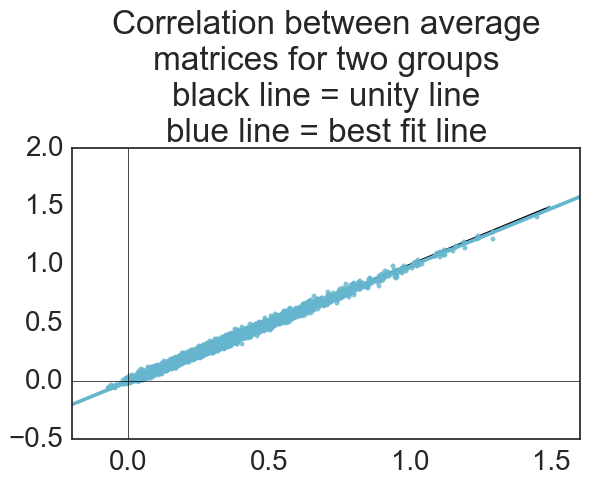

In [81]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = M_grA_av[indices]
grB_values = M_grB_av[indices]

min_val = np.min([np.nanmin(grA_values), np.nanmin(grB_values)])
max_val = np.max([np.nanmax(grA_values), np.nanmax(grB_values)])

mask_nans = np.logical_or(np.isnan(grA_values), np.isnan(grB_values))

fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(grA_values[~mask_nans],
            grB_values[~mask_nans],
            color = sns.color_palette()[5],
            scatter_kws={'s' : 10, 'edgecolor' : 'face'}, 
            ax=ax)

ax.plot([min_val, max_val], [min_val, max_val], c='k', zorder=-1)

ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation between average\nmatrices for two groups\nblack line = unity line\nblue line = best fit line')

plt.tight_layout()

**This looks like a very good fit! **

Let's check what the actual Rsq is with our function - we expect it to be super high!

In [82]:
Rsq=calc_rsq( M_grA_av,  M_grB_av)
Rsq

0.98805956486476887

## Run this split half calculation multiple times to get a distribution R square values

We want to build up a distribution of R sqaured values per specific motion cutoff, age range, and N combinations 

In [83]:
def split_half_outcome(df, motion_thresh, age_l, age_u, n, n_perms=100):
    
    """
    This function returns the R squared of how each parameter affects split-half reliability!
    It takes in a dataframe, motion threshold, an age upper limit(age_u) an age lower limit (age_l), sample size (n),
    and number of permutations (n_perms, currently hard coded at 100). This function essentially splits a data frame 
    into two matched samples (split_two_matched_samples.py), then creates mean roi-roi correlation matrices per sample 
    (make_group_corr_mat.py) and then calculates the R squared (calc_rsq.py) between the two samples'
    correlation matrices and returns all the permuation coefficients of determinations in a dataframe.
    """
    
    #set up data frame of average R squared to fill up later
    Rsq_list = []
    
    #Do this in each permutation
    for i in range(n_perms):
        #create two matched samples split on motion_thresh, age upper, age lower, and n
        df_A, df_B = split_two_matched_samples(df, motion_thresh, age_l, age_u, n)
        #make the matrix of all subjects roi-roi correlations, make the mean corr mat, and make covariance cor mat
        #do this for A and then B
        all_corr_mat_A, av_corr_mat_A, var_corr_mat_A = make_group_corr_mat(df_A)
        all_corr_mat_B, av_corr_mat_B, var_corr_mat_B = make_group_corr_mat(df_B)
        
        #calculate the R squared between the two matrices
        Rsq = calc_rsq(av_corr_mat_A, av_corr_mat_B)
        
        #print "Iteration " + str(i) + ": R^2 = " + str(Rsq) 
        
        #build up R squared output
        Rsq_list += [Rsq]
    
    return np.array(Rsq_list)

In [84]:
rsq_list = split_half_outcome(df, 50, 6, 18, 20, n_perms=100)

### Plot R sqr values

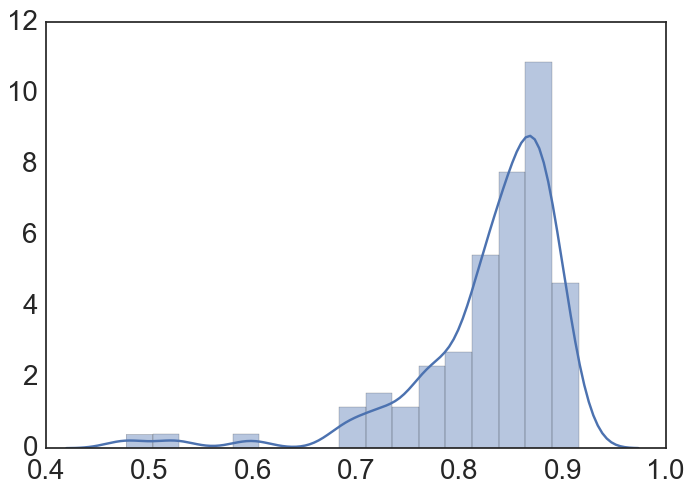

In [85]:
sns.distplot(rsq_list )

This is not a normal distribution, so when we want to plot the average Rsq value for a certain combination of age, motion cutoff and n, **we should take the median of Rsq** not the mean

## We can wrap everything we just did into one big function

The function iterates through different sample sizes, age bins, and motion cutoffs for a specific amount of permutations and:
* Creates 2 split half samples
* Creates average roi-roi correlation matrices for each sample
* Calculates R squared value for fit of the two samples mean roi-roi corrlelation matrices
* Creates csvs of median Rsq and 95% confidence intervals per each motion, age, and sample size iteration

**Note**: the output csvs will be saved in `RESULTS` and will be labeled based on their specific input criteria. So for example, if the motion threshold was 50, age lower was 6, age upper was 10 and n=20, the csv output would be `rsq_050pct_020subs_06to08.csv`

In [86]:
def abide_motion_wrapper(motion_thresh, age_l, age_u, n, n_perms=1000, overwrite=True):
    behav_data_f = 'DATA/Phenotypic_V1_0b_preprocessed1.csv'
       
    f_name = 'RESULTS/rsq_{:03.0f}pct_{:03.0f}subs_{:02.0f}to{:02.0f}.csv'.format(motion_thresh, n, age_l, age_u)
    
    # By default this code will recreate files even if they already exist
    # (overwrite=True)
    # If you don't want to do this though, set overwrite to False and 
    # this step will skip over the analysis if the file already exists
    if not overwrite:
        # If the file exists then skip this loop
        if os.path.isfile(f_name):
            return
    
    df = read_in_data(behav_data_f)

    rsq_list = split_half_outcome(df, motion_thresh, age_l, age_u, n, n_perms=n_perms)
    
    #print "R Squared list shape: " + str(rsq_list.shape)
    
    med_rsq = np.median(rsq_list)
    rsq_CI = np.percentile(rsq_list, 97.5) - np.percentile(rsq_list, 2.5)

    columns = [ 'motion_thresh', 'age_l', 'age_u', 'n', 'med_rsq', 'CI_95' ]
    results_df = pd.DataFrame(np.array([[motion_thresh, age_l, age_u, n, med_rsq, rsq_CI ]]), 
                                  columns=columns)


    results_df.to_csv(f_name)


### If you want to just run it with `abide_motion_wrapper.py` you will need to use `loop_abide_motion_qsub_array.sh`  and `SgeAbideMotion.sh`

`loop_abide_motion_qsub_array.sh` loops through age, motion, and sample sizes of interest. To actually run the code (looping through all iteration) run `SgeAbideMotion.sh`. This is also where you can choose how to submit jobs (and parralalize or not)

### Once you have finished running the code, you will want to summarize the data for plotting

This code grabs and formats the data for plotting into a summary file call `SummaryRsqs.csv` that has columns for: motion threshold, median Rsq, 95% CI for R sqr, sample size, age lower, and age upper. It will be in the `RESULTS` folder.

In [ ]:
columns = [ 'motion_thresh', 'med_rsq', 'CI_95', 'n', 'age_l', 'age_u']
results_df = pd.DataFrame(columns = columns)

for f in glob('RESULTS/*csv'):
    temp_df = pd.read_csv(f, index_col=0)
    results_df = results_df.append(temp_df)
    
results_df.to_csv('RESULTS/SummaryRsqs.csv', index=None, columns=columns)

### We like R for plotting, so once the data is ready, head over to `plotting_R` to plot things :)